In [1]:
try:
    import google.colab  # noqa: F401

    %pip install -q dataeval
except Exception:
    pass

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
from functools import partial

import numpy as np
import tensorflow_datasets as tfds
import torch

from dataeval.detectors import (
    DriftCVM,
    DriftKS,
    DriftMMD,
    preprocess_drift,
)
from dataeval.models.torch import AriaAutoencoder

device = "cuda" if torch.cuda.is_available() else "cpu"

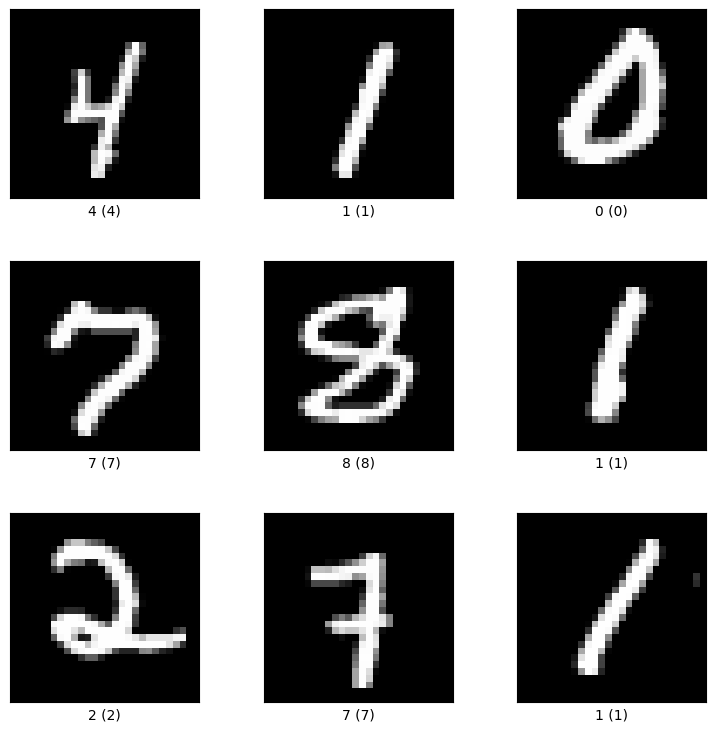

In [3]:
# Load in the mnist dataset from tensorflow datasets
dataset, ds_info = tfds.load(
    "mnist",
    split="train[:4000]",
    with_info=True,
)
tfds.visualization.show_examples(dataset, ds_info)
dataset = dataset.shuffle(dataset.cardinality())
dataset = [i["image"] for i in dataset]
dataset = np.array(dataset, dtype=np.float32).transpose(0, 3, 1, 2)

In [4]:
print("Number of samples: ", len(dataset))
print("Image shape:", dataset[0].shape)

Number of samples:  4000
Image shape: (1, 28, 28)


In [5]:
data_reference = dataset[0:2000]
data_control = dataset[2000:]

In [6]:
# define encoder
encoder_net = AriaAutoencoder(1).encoder.to(device)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=64, device=device)

# initialise drift detectors
detectors = [detector(data_reference, preprocess_fn=preprocess_fn) for detector in [DriftMMD, DriftCVM, DriftKS]]

In [7]:
[(type(detector).__name__, detector.predict(data_control)["is_drift"]) for detector in detectors]

[('DriftMMD', 0), ('DriftCVM', 0), ('DriftKS', 0)]

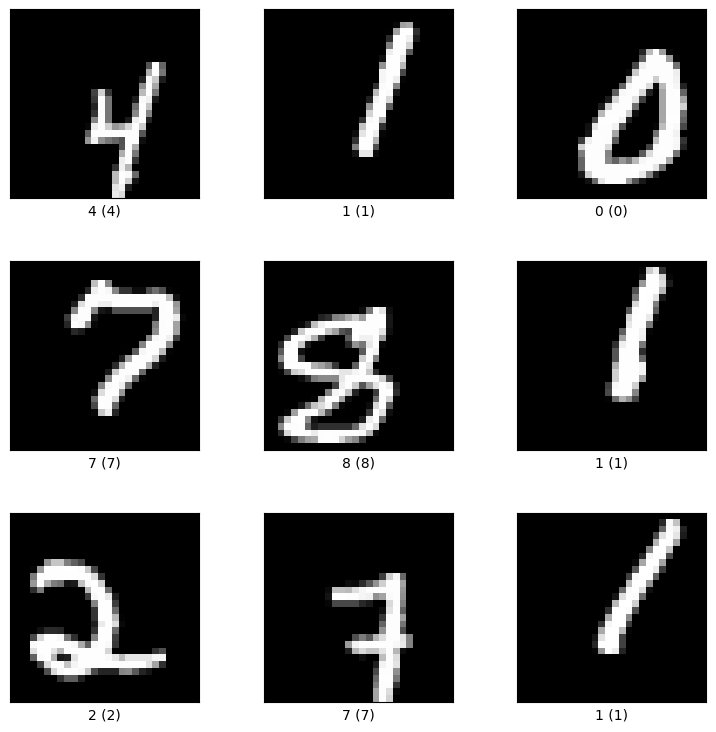

In [8]:
corrupted, ds_info = tfds.load(
    "mnist_corrupted/translate",
    split="train[:2000]",
    with_info=True,
)
tfds.visualization.show_examples(corrupted, ds_info)
corrupted = corrupted.shuffle(corrupted.cardinality())
corrupted = [i["image"] for i in corrupted]
corrupted = np.array(corrupted, dtype=np.float32).transpose(0, 3, 1, 2)

In [9]:
print("Number of corrupted samples: ", len(corrupted))
print("Corrupted image shape:", corrupted[0].shape)

Number of corrupted samples:  2000
Corrupted image shape: (1, 28, 28)


In [10]:
[(type(detector).__name__, detector.predict(corrupted)["is_drift"]) for detector in detectors]

[('DriftMMD', 1), ('DriftCVM', 1), ('DriftKS', 1)]